# Infected HDiff Infectizer

## Change Working Directory

In [1]:
import os
os.chdir("..")

## Imports

In [2]:
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import torchaudio
import IPython

from loaders.build import build_mel_spec_module
from models.build import build_diffwave_diffusion_vocoder, build_mel_spec_converter
from utils.containers import MelSpecParameters, LearningParameters, DiffusionParameters, MusicDatasetParameters
from utils.others import load_config

## Load Config

In [3]:
cfg_path = "config/config.yaml"
cfg = load_config(cfg_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The current device is {device.upper()}")

weights_path = "weights/vocoder/diffwave_best.ckpt"

The current device is CUDA


## Load Model

In [4]:
vocoder = build_diffwave_diffusion_vocoder(cfg, weights_path=weights_path).eval().to(device)
print(f"Loaded vocoder from path {weights_path}")

Loaded vocoder from path weights/vocoder/diffwave_best.ckpt


## Load Dataset

In [5]:
dataset_params = MusicDatasetParameters(**cfg["dataset"])
learning_params = LearningParameters(**cfg["learning"])
learning_params.batch_size = 1
mel_spec_params = MelSpecParameters(**cfg["image_mel_spec_params"])
data_module = build_mel_spec_module(dataset_params, learning_params, mel_spec_params)

Parsing slices to buffer...: 100%|██████████| 2/2 [00:00<00:00, 31.86it/s]

Parsed metadata and the slices to the buffer


## Load Datapoint

In [6]:
data_module.setup("fit")
loader = data_module.train_dataloader()
for batch in loader:
    print(f"File name: {batch['slice_file_name'][0]}")
    print(f"File index: {batch['slice_idx'].item()}")
    print(f"The slice dimensions are {tuple(batch['slice'].shape)}")
    slice = batch["slice"]
    break

File name: slices_Infected_Mushroom_&_Bliss_-_Ani_Mevushal_[Monstercat_Release].pt
File index: 127
The slice dimensions are (1, 1, 32768)


## Create Player Object

In [7]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Show Mel Spectrogram

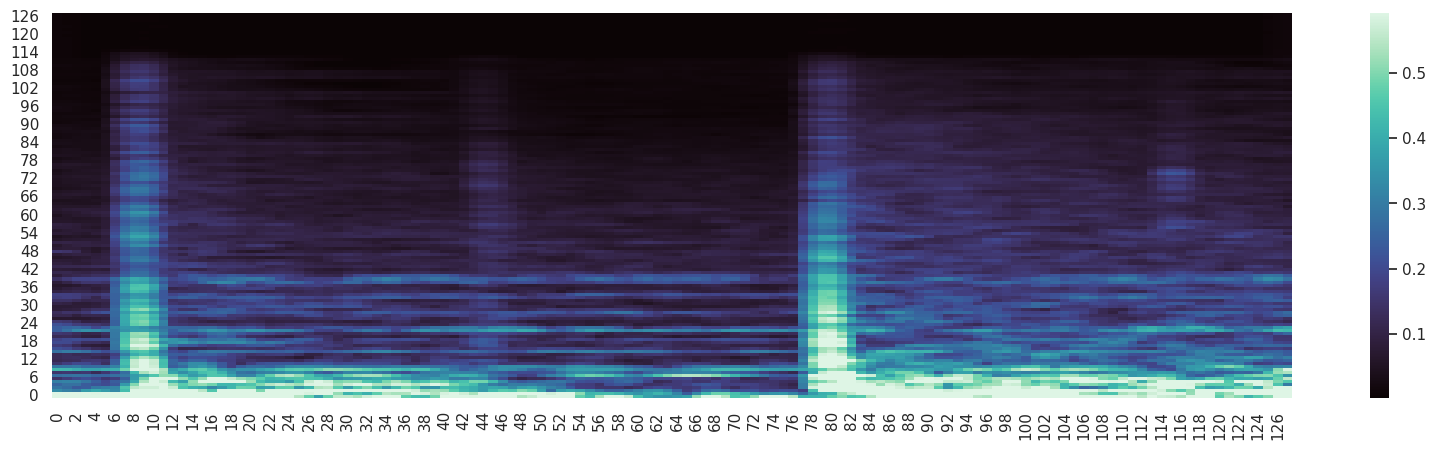

In [8]:
mel_spec_converter = build_mel_spec_converter("simple", mel_spec_params)
slice_mel_spec = mel_spec_converter.convert(slice)
sns.set(rc={'figure.figsize':(20, 5)})
ax = sns.heatmap(slice_mel_spec.squeeze(0).squeeze(0).cpu().numpy(), robust=True, cmap="mako")
ax.invert_yaxis()

## Show Waveform and Play It

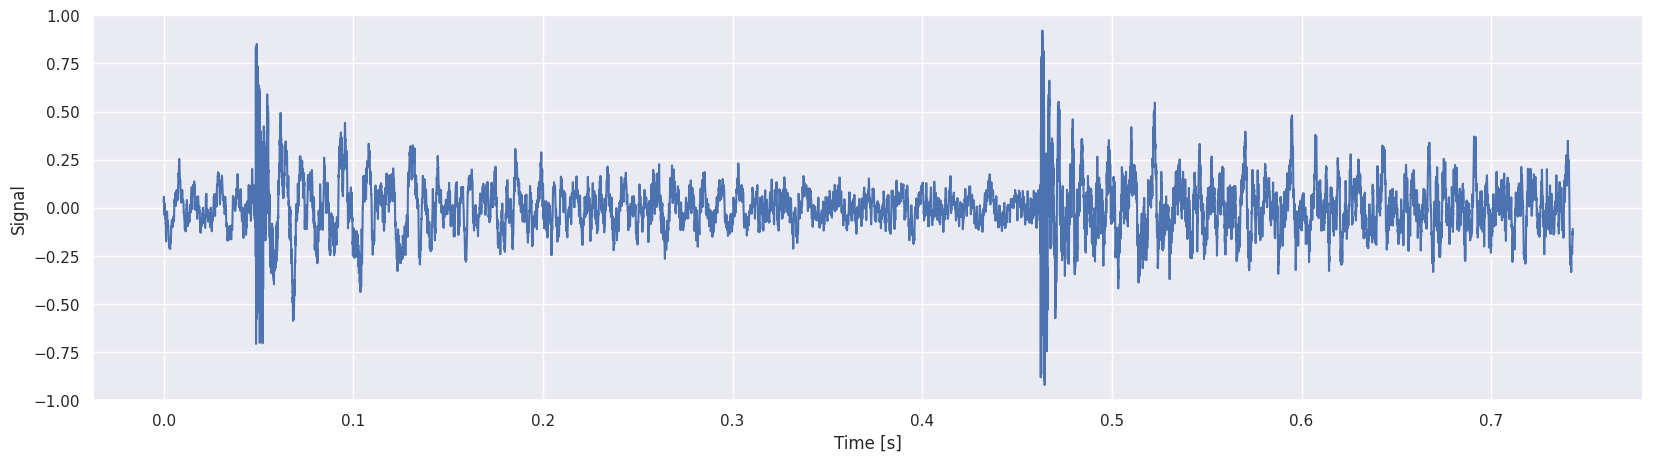

In [9]:
x = (np.array(range(slice.shape[-1])) + 1) / dataset_params.sample_rate
y = slice.squeeze(0).squeeze(0).cpu().numpy()
data = pd.DataFrame({"Time [s]": x, "Signal": y})
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20, 5)})
ax = sns.lineplot(data=data, x="Time [s]", y="Signal")
ax.set_ylim((-1, 1))
torchaudio.save('sample_out.mp3', slice.squeeze(0).cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

## Show Scheduling Constants

<Axes: >

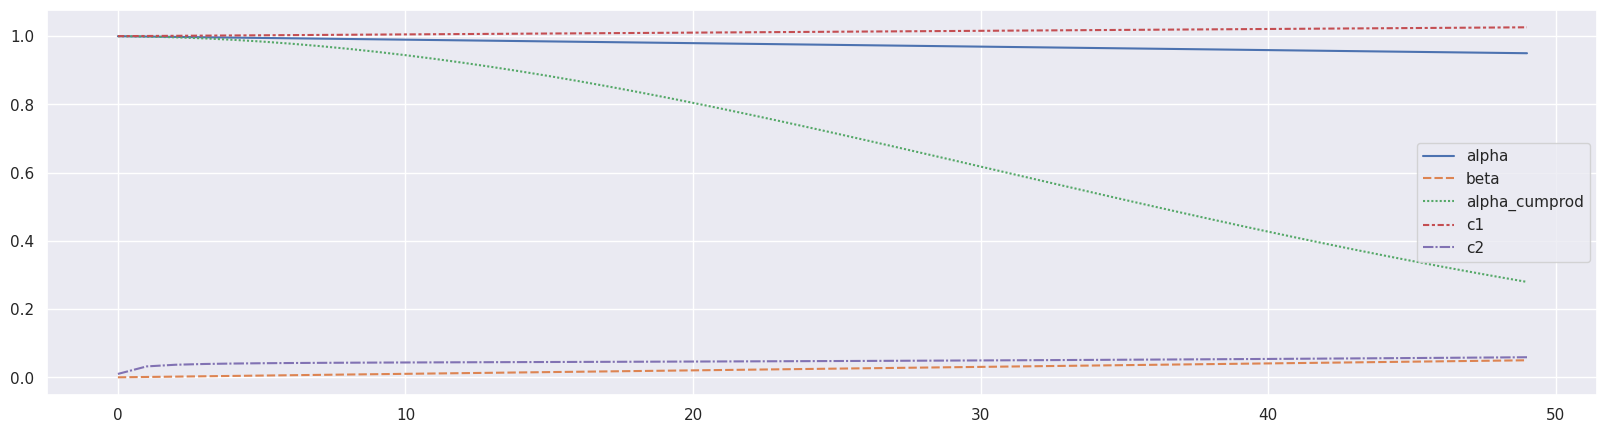

In [10]:
scheduler = vocoder.diffusion_params.scheduler

# plot parameter development
sns.set_style("darkgrid")
data = {"alpha": scheduler.alphas.cpu().numpy(), "beta": scheduler.betas.cpu().numpy(), "alpha_cumprod": scheduler.alphas_cumprod.cpu().numpy(),
        "c1": 1 / scheduler.alphas.cpu().numpy() ** 0.5, 
        "c2": scheduler.betas.cpu().numpy() / (1 - scheduler.alphas_cumprod.cpu().numpy()) ** 0.5
}

sns.lineplot(data)


## Reconstruct the Sound Wave

In [11]:
noisy_input = {"noisy_slice": torch.randn_like(slice.squeeze(1))}
cond_input = {"mel_spec": slice_mel_spec.squeeze(1)}
reconstructed_output = vocoder.denoise(noisy_input, cond_input, show_process_plots=False)
reconstructed_slice = reconstructed_output["denoised_slice"]

## Play the Reconstructed Slice

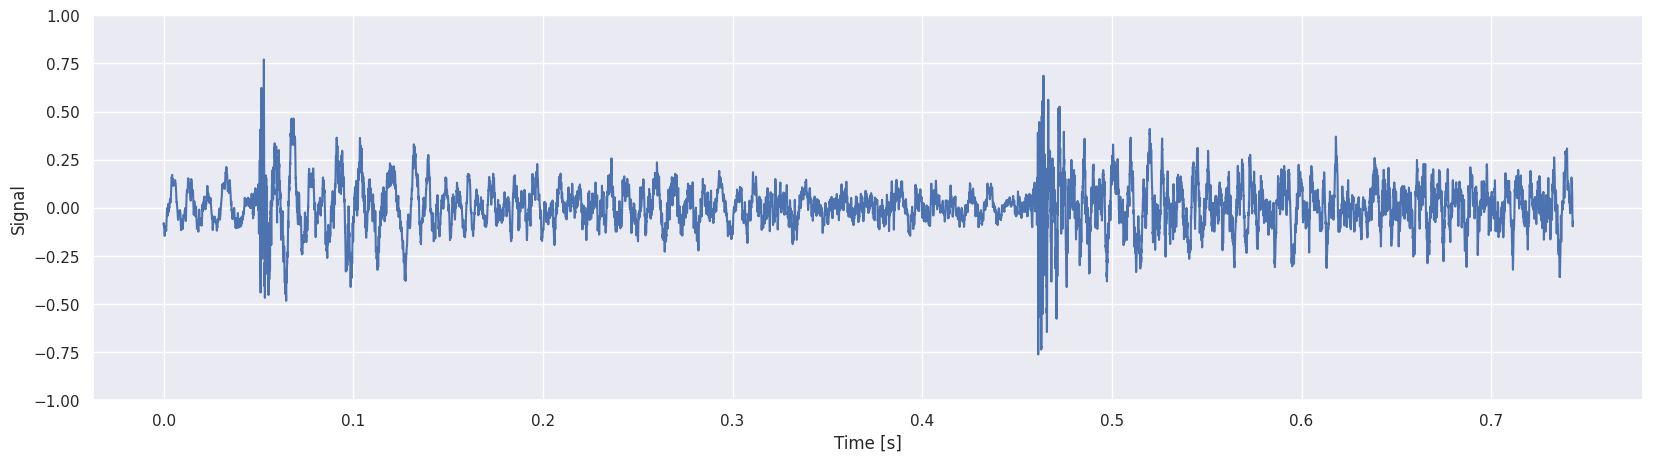

In [12]:
x = (np.array(range(slice.shape[-1])) + 1) / dataset_params.sample_rate
y = reconstructed_slice.squeeze(0).cpu().numpy()
data = pd.DataFrame({"Time [s]": x, "Signal": y})
sns.set(rc={'figure.figsize':(20, 5)})
ax = sns.lineplot(data=data, x="Time [s]", y="Signal")
ax.set_ylim((-1, 1))
torchaudio.save('sample_out.mp3', reconstructed_slice.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

## Try and Load a Different Music Track

In [13]:
import random


test_track_path = "data/test_tracks/bhaalspawn.mp3"
slice_new_big: torch.Tensor = torchaudio.load(test_track_path, format="mp3")[0]
slice_new_big = slice_new_big.mean(dim=0, keepdim=True)
slice_start_idx = int(random.random() * 8e6)
slice_new = slice_new_big[:, slice_start_idx: slice_start_idx + 32768]

## Play The Slice, Display Waveform

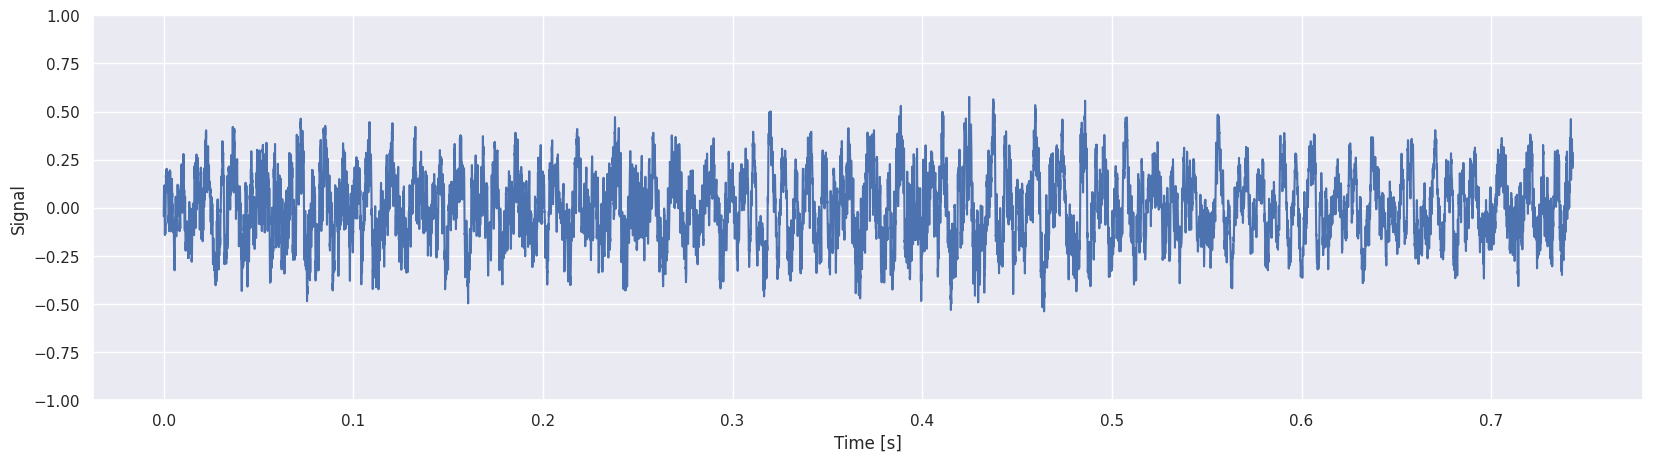

In [14]:
x = (np.array(range(slice.shape[-1])) + 1) / dataset_params.sample_rate
y = slice_new.squeeze(0).cpu().numpy()
data = pd.DataFrame({"Time [s]": x, "Signal": y})
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20, 5)})
ax = sns.lineplot(data=data, x="Time [s]", y="Signal")
ax.set_ylim((-1, 1))

torchaudio.save('sample_out.mp3', slice_new.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

## Display Mel-Spec

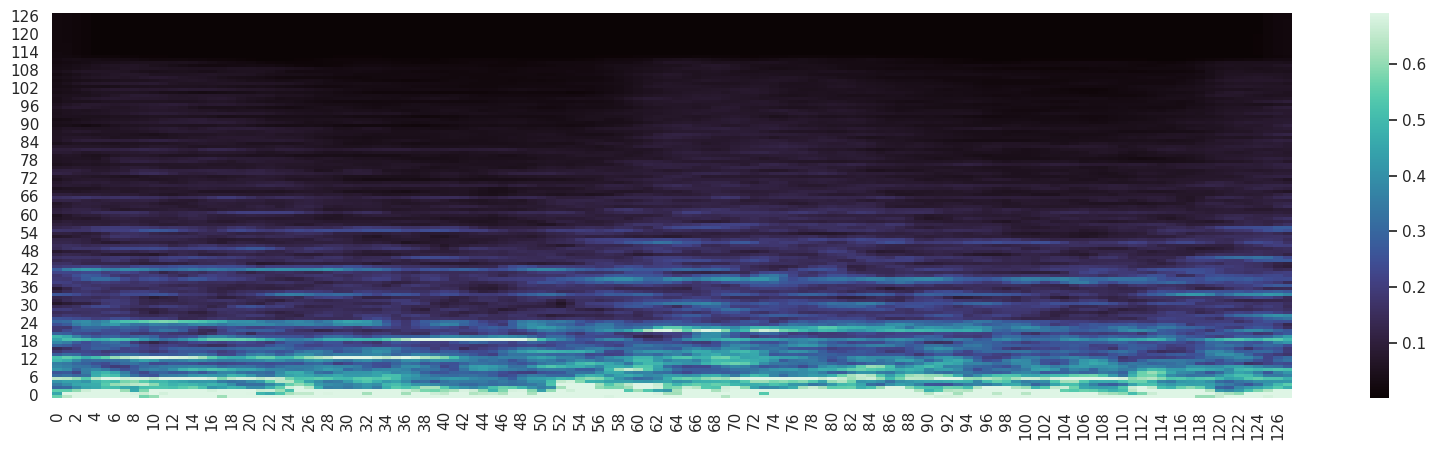

In [15]:
slice_mel_spec = mel_spec_converter.convert(slice_new)
ax = sns.heatmap(slice_mel_spec.squeeze(0).squeeze(0).cpu().numpy(), robust=True, cmap="mako")
ax.invert_yaxis()

## Pass The Mel-Spec Through the Denoiser

In [16]:
noisy_input = {"noisy_slice": torch.randn_like(slice_new.squeeze(1))}
cond_input = {"mel_spec": slice_mel_spec.squeeze(1)}
reconstructed_output = vocoder.denoise(noisy_input, cond_input, show_process_plots=False)
reconstructed_slice = reconstructed_output["denoised_slice"]

## Display and Play the Reconstructed Slice

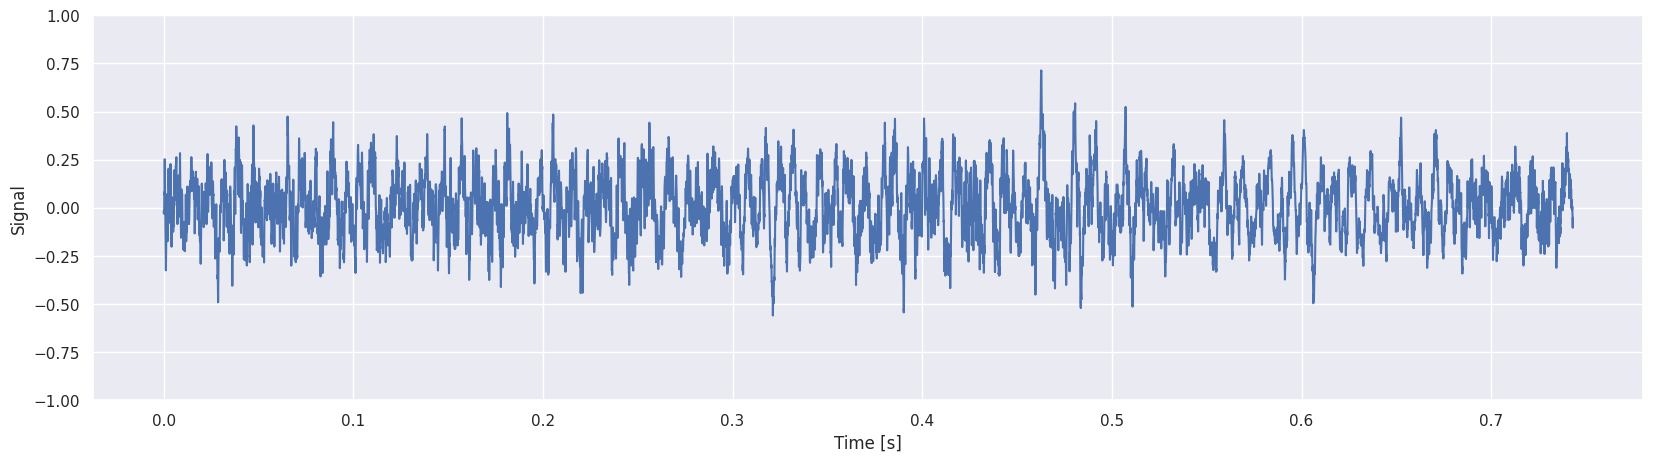

: 

In [17]:
x = (np.array(range(slice.shape[-1])) + 1) / dataset_params.sample_rate
y = reconstructed_slice.squeeze(0).cpu().numpy()
data = pd.DataFrame({"Time [s]": x, "Signal": y})
sns.set(rc={'figure.figsize':(20, 5)})
ax = sns.lineplot(data=data, x="Time [s]", y="Signal")
ax.set_ylim((-1, 1))
torchaudio.save('sample_out.mp3', reconstructed_slice.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")